In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from datetime import datetime
from pprint import pprint
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

In [2]:
### Produce loan recurrence clean data for web app

In [3]:
usecols = ['CompanyName', 'CompanyNumber', 'Sics', 'CompanyStatus', 'RegAddress.PostCode', 'IncorporationDate',
           'Mortgages.NumMortCharges']

corig = pd.read_csv('ch_companies_clean_1.csv', index_col=None, 
                    usecols=usecols, dtype={'CompanyNumber': str})

print(corig.shape)
corig.head(2)

(4400981, 7)


,CompanyName,CompanyNumber,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges
0,! LTD,08209948,99999 - Dormant Company,LS10 2RU,Active,11/09/2012,0
1,!? LTD,11399177,47710 - Retail sale of clothing in specialised...,SK6 3DY,Active,05/06/2018,0


In [4]:
usecols = ['CompanyNumber', 'charge_number', 'delivered_on']

horig = pd.read_csv('ch_charges_clean_1.csv', 
                    index_col=None, 
                    usecols=usecols, 
                    dtype={'CompanyNumber': str})

print(horig.shape)
horig.head()

(2442388, 3)


,CompanyNumber,charge_number,delivered_on
0,00609565,116,1988-02-15T00:00:00.000Z
1,00609565,115,1988-01-15T00:00:00.000Z
2,00609565,114,1987-12-11T00:00:00.000Z
3,00609565,113,1987-11-20T00:00:00.000Z
4,00609565,112,1987-11-10T00:00:00.000Z


In [5]:
cedit = corig.copy()
hedit = horig.copy()

## Clean and Merge Data

In [6]:
### all Sics
cedit = cedit[cedit.CompanyStatus == 'Active']
cedit['Outcode'] = cedit['RegAddress.PostCode'].astype(str).str[:2]
cedit = cedit[(cedit.Outcode.isin(['SE', 'SW', 'NW', 'EC']))]

print(cedit.shape)

(370818, 8)


In [55]:
medit = pd.merge(hedit, cedit, how='right', on='CompanyNumber')

print(medit.shape)
medit.head(2)

(645332, 10)


,CompanyNumber,charge_number,delivered_on,CompanyName,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges,Outcode
0,02059181,65.0,2006-12-22T00:00:00.000Z,PINTON ESTATES PLC,7011 - Development & sell real estate,EC4A 3TR,Active,26/09/1986,65,EC
1,02059181,64.0,2004-09-21T00:00:00.000Z,PINTON ESTATES PLC,7011 - Development & sell real estate,EC4A 3TR,Active,26/09/1986,65,EC


In [56]:
### Our Falses; False if the event was lost (right-censored). 
medit.tail(2)

,CompanyNumber,charge_number,delivered_on,CompanyName,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges,Outcode
645330,12049944,NaN,NaN,ŜANĜO C.I.C.,46190 - Agents involved in the sale of a varie...,SE1 7FR,Active,13/06/2019,0,SE
645331,09511422,NaN,NaN,“SAIL IN GREECE ADVENTURES” LTD,79120 - Tour operator activities,EC1A 2BN,Active,26/03/2015,0,EC


In [57]:
def first_sic(x):
    return x.split(' ')[0]

In [58]:
def event(x):
    if x == 0:
        return 0
    else:
        return 1

In [59]:
medit = medit[medit.Sics != 'None Supplied']
medit['Sic'] = medit.Sics.apply(first_sic)
medit.delivered_on.fillna(value=datetime.now(), inplace=True)
medit.delivered_on = pd.to_datetime(medit.delivered_on, utc=True)
medit.IncorporationDate = pd.to_datetime(medit.IncorporationDate, utc=True)
medit['Event'] = medit['Mortgages.NumMortCharges'].apply(event)
medit = medit[medit.IncorporationDate > '1990-01-01']
medit['Tenure'] = (medit.delivered_on - medit.IncorporationDate).dt.days
medit = medit[medit.Tenure > 0]

print(medit.shape)
medit.head(2)

(522148, 13)


,CompanyNumber,charge_number,delivered_on,CompanyName,Sics,RegAddress.PostCode,CompanyStatus,IncorporationDate,Mortgages.NumMortCharges,Outcode,Sic,Event,Tenure
65,03898937,4.0,2006-08-22 00:00:00+00:00,RIDGECROFT PROPERTIES LIMITED,"7012 - Buying & sell own real estate, 7020 - L...",EC4A 3TR,Active,1999-12-23 00:00:00+00:00,4,EC,7012,1,2434
66,03898937,3.0,2006-07-28 00:00:00+00:00,RIDGECROFT PROPERTIES LIMITED,"7012 - Buying & sell own real estate, 7020 - L...",EC4A 3TR,Active,1999-12-23 00:00:00+00:00,4,EC,7012,1,2409


In [60]:
medit.Event.value_counts()

0    299370
1    222778
Name: Event, dtype: int64

In [61]:
# keeping only the first charge for each company
medit = medit.loc[medit.groupby('CompanyNumber')['Tenure'].idxmin()]

print(len(medit))
print(len(medit.CompanyNumber.unique()))

339504
339504


In [65]:
medit = medit[['CompanyName', 'CompanyNumber', 'Outcode', 'Sic', 'Tenure', 'Event']]
medit.sort_values(by=['CompanyNumber', 'Sic'], ascending=True, inplace=True)
medit.reset_index(drop=True, inplace=True)

medit.head(2)

,CompanyName,CompanyNumber,Outcode,Sic,Tenure,Event
0,2 ERSKINE ROAD MANAGEMENT LIMITED,02456613,NW,98000,10902,0
1,CLIMBLODGE LIMITED,02456689,NW,41100,1345,1


In [66]:
# medit.to_csv('loan_1st_by_sic.csv')

## Start SA 

In [34]:
kmf = KaplanMeierFitter()

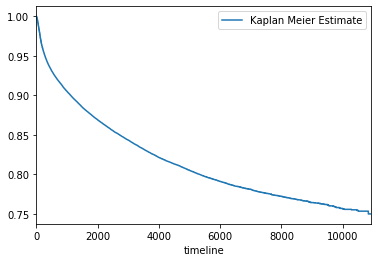

In [35]:
kmf.fit(medit.Tenure, medit.Event, label='Kaplan Meier Estimate')
kmf.plot(ci_show=False)

In [39]:
T = medit.Tenure
E = medit.Event
groups = medit.Sic
chemists = (groups == '47730')
dentists = (groups == '86230')

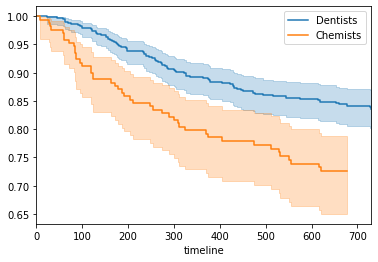

In [40]:
kmf1 = KaplanMeierFitter()

## fit the model for 1st cohort
kmf1.fit(T[dentists], E[dentists], label='Dentists')
a1 = kmf1.plot(loc=slice(0, 730))

## fit the model for 2nd cohort
kmf1.fit(T[chemists], E[chemists], label='Chemists')
kmf1.plot(ax=a1, loc=slice(0, 730))

In [42]:
dedit = medit.copy()
dedit = dedit[dedit.Sic == '86230']

T2 = dedit.Tenure
E2 = dedit.Event
groups = dedit.Outcode
se = (groups == 'SE')
sw = (groups == 'SW')
nw = (groups == 'NW')

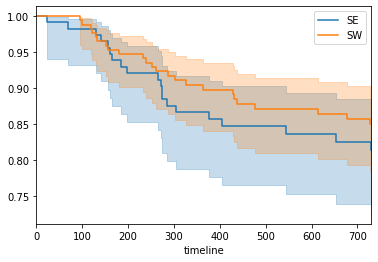

In [43]:
kmf2 = KaplanMeierFitter()

kmf2.fit(T2[se], E2[se], label='SE')
a2 = kmf2.plot(loc=slice(0, 730))


kmf2.fit(T2[sw], E2[sw], label='SW')

kmf2.plot(ax=a2, loc=slice(0, 730))